In [1]:
import numpy as np
import sympy as sp
from sympy.utilities.lambdify import lambdify
from scipy.integrate import solve_bvp, solve_ivp
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from scipy.optimize import root

In [2]:
def make_video(t_solution, y_solution, D=2, S=1, name="dogs_sheep_animation"):
    ts = t_solution
    num_agents = D + S
    
    # Split y_solution into positions and velocities
    positions = y_solution[:4 * num_agents]
    
    # Extract x and y coordinates
    x_coords = positions[::4]  # Every 4th element starting at index 0
    y_coords = positions[1::4]  # Every 4th element starting at index 1
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(min([np.min(x) for x in x_coords]) - 1, max([np.max(x) for x in x_coords]) + 1)
    ax.set_ylim(min([np.min(y) for y in y_coords]) - 1, max([np.msax(y) for y in y_coords]) + 1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Animation of State Evolution')
    
    # Assign colors: Green for dogs, Red for sheep
    colors = ['g'] * D + ['r'] * S
    markers = ['o'] * num_agents
    
    # Initialize points and trails
    points = [ax.plot([], [], color + markers[i], markersize=8)[0] for i, color in enumerate(colors)]
    trails = [ax.plot([], [], color + '-', alpha=0.5)[0] for color in colors]
    
    # Lists to store trail paths
    trail_x, trail_y = [[] for _ in range(num_agents)], [[] for _ in range(num_agents)]
    
    # Add a marker at the origin and legend
    ax.plot(0, 0, 'kX', markersize=5)
    ax.grid(True)
    ax.legend([points[i] for i in range(num_agents)], [f'Agent {i+1}' for i in range(num_agents)])
    
    # Update function for animation
    def update(frame):
        for i in range(num_agents):
            points[i].set_data([x_coords[i][frame]], [y_coords[i][frame]])
            trail_x[i].append(x_coords[i][frame])
            trail_y[i].append(y_coords[i][frame])
            trails[i].set_data(trail_x[i], trail_y[i])
        return points + trails
    
    # Create animation
    ani = animation.FuncAnimation(fig, update, frames=len(ts), interval=50, blit=True)
    ani.save(name + '.mp4', writer='ffmpeg', fps=30)
    
    print(f"Video saved at {name}.mp4")
    plt.show()

Consider a problem where we have just 2 dogs and one sheep. Let $(x_{d_i},y_{d_i})$ be the position of the ith dog and $(v_{x_{d_i}},v_{y_{d_i}})$ be the velocity vector of the ith dog. Also, let $(u_1,u_2)$ be the acceleration (control) of the first and $(u_3,u_4)$ the acceleration (control) of the second. 

Thus, we have the state evolution equation $\frac{d}{dt}\begin{bmatrix}x_{d_1}\\y_{d_1}\\v_{x_{d_1}}\\v_{y_{d_1}}\\x_{d_2}\\y_{d_2}\\v_{x_{d_2}}\\v_{y_{d_2}}\\x_{s_1}\\y_{s_1}\\v_{x_{s_1}}\\v_{y_{s_1}}\end{bmatrix}=\begin{bmatrix}v_{x_{d_1}}\\v_{y_{d_1}}\\u_1\\u_2\\v_{x_{d_2}}\\v_{y_{d_2}}\\u_3\\u_4\\v_{x_{s_1}}\\v_{y_{s_1}}\\a \\ b
\end{bmatrix}$ where $a=\frac{x_{s_1}-x_{d_1}}{[(x_{s_1}-x_{d_1})^2+(y_{s_1}-y_{d_1})^2]^{\lambda/2}}+\frac{x_{s_1}-x_{d_2}}{[(x_{s_1}-x_{d_2})^2+(y_{s_1}-y_{d_2})^2]^{\lambda/2}}$ and $b=\frac{y_{s_1}-y_{d_1}}{[(x_{s_1}-x_{d_1})^2+(y_{s_1}-y_{d_1})^2]^{\lambda/2}}+\frac{y_{s_1}-y_{d_2}}{[(x_{s_1}-x_{d_2})^2+(y_{s_1}-y_{d_2})^2]^{\lambda/2}}$. 

We originally had the cost functional $J[u]=\int_0^{t_f}[\alpha (x_{s_1}^2+y_{s_1}^2)+u_1^2+u_2^2+u_3^2+u_4^2]dt$. However, upon further testing, the dogs went off far in all directions. So, to keep them close to the center as well, we let $J[u]=\int_0^{t_f}[\alpha (x_{s_1}^2+y_{s_1}^2) +\beta(x_{d_1}^2+y_{d_1}^2+x_{d_2}^2+y_{d_2}^2) +u_1^2+u_2^2+u_3^2+u_4^2]dt$

Putting this altogether, gives the Hamiltonian $H=p\cdot f-L=p_1v_{x_{d_1}}+p_2v_{y_{d_1}}+p_3u_1+p_4u_2+p_5v_{x_{d_2}}+p_6v_{y_{d_2}}+p_7u_3+p_8u_4+p_9v_{x_{s_1}}+p_{10}v_{y_{s_1}}+p_{11}a+p_{12}b-\alpha x_{s_1}^2-\alpha y_{s_1}^2-\beta x_{d_1}^2-\beta y_{d_1}^2- \beta x_{d_2}^2- \beta y_{d_2}^2-u_1^2-u_2^2-u_3^2-u_4^2$

This gives the co-state evolution equation $p'=-\frac{DH}{Dx}=-\begin{bmatrix}p_{11}\frac{da}{dx_{d_1}}+p_{12}\frac{db}{dx_{d_1}}-2\beta x_{d_1}\\ p_{11}\frac{da}{dy_{d_1}}+p_{12}\frac{db}{dy_{d_1}}- 2\beta y_{d_1}\\p_1\\p_2\\p_{11}\frac{da}{dx_{d_2}}+p_{12}\frac{db}{dx_{d_2}} - 2\beta x_{d_2}\\p_{11}\frac{da}{dy_{d_2}}+p_{12}\frac{db}{dy_{d_2}} - 2\beta y_{d_2}\\p_5\\p_6\\p_{11}\frac{da}{dx_{s_1}}+p_{12}\frac{db}{dx_{s_1}}-2\alpha x_{s_1}\\p_{11}\frac{da}{dy_{s_1}}+p_{12}\frac{db}{dy_{s_1}}-2\alpha y_{s_1}\\p_9\\p_{10}\end{bmatrix}$. To keep things clean, we avoid computing the derivatives of $a$ and $b$. It will suffices to use Sympy to compute the derivatives.

In [3]:
# Define variables
xd1, yd1, vxd1, vyd1, \
xd2, yd2, vxd2, vyd2, \
xs1, ys1, vxs1, vys1 = \
sp.symbols('x_d1 y_d1 v_xd1 v_yd1 x_d2 y_d2 v_xd2 v_yd2 x_s1 y_s1 v_xs1 v_ys1')
p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12 = sp.symbols('p1 p2 p3 p4 p5 p6 p7 p8 p9 p10 p11 p12')
u1, u2, u3, u4 = sp.symbols('u1 u2 u3 u4')
lambd, alpha, beta = 3, 30, 2
epsilon = 1e-3  # Small constant to prevent division by zero

# Define squared distances
r1_sq = (xs1 - xd1)**2 + (ys1 - yd1)**2 + epsilon
r2_sq = (xs1 - xd2)**2 + (ys1 - yd2)**2 + epsilon

# Define a and b
a_left = (xs1 - xd1) / (r1_sq**(lambd / 2))
a_right = (xs1 - xd2) / (r2_sq**(lambd / 2))
a = a_left + a_right
b_left = (ys1 - yd1) / (r1_sq**(lambd / 2))
b_right = (ys1 - yd2) / (r2_sq**(lambd / 2))
b = b_left + b_right

# Define the Hamiltonian
L = alpha*xs1**2 + alpha*ys1**2 + u1**2 + u2**2 + u3**2 + u4**2
L += beta*xd1**2 + beta*yd1**2 + beta*xd2**2 + beta*yd2**2  # Penalize dogs from being too far from the origin
H = p1*vxd1 + p2*vyd1 + p3*u1 + p4*u2 + p5*vxd2 + p6*vyd2 + p7*u3 + p8*u4 + p9*vxs1 + p10*vys1 + p11*a + p12*b - L
    
# Define state and costate vectors
state_vars = [xd1, yd1, vxd1, vyd1, xd2, yd2, vxd2, vyd2, xs1, ys1, vxs1, vys1]
costate_vars = [p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11, p12]

# Compute and simplify state and costate equations
dx_dt = [sp.simplify(sp.diff(H, p)) for p in costate_vars]
dp_dt = [sp.simplify(-sp.diff(H, x)) for x in state_vars]

# Compute optimal control
control_eqs = [sp.simplify(sp.diff(H, u)) for u in [u1, u2, u3, u4]]
optimal_controls = sp.solve(control_eqs, [u1, u2, u3, u4])

# Write state and cos-state equation in terms of each other
dx_dt_opt = [expr.subs(optimal_controls) for expr in dx_dt]
dp_dt_opt = [expr.subs(optimal_controls) for expr in dp_dt]

# Create a function for dx/dt and dp/dt
dx_dt_func = lambdify(state_vars + costate_vars, dx_dt_opt, 'numpy')
dp_dt_func = lambdify(state_vars + costate_vars, dp_dt_opt, 'numpy')

In [4]:
import sys
def ode(t, y):    
    state = y[:12]
    costate = y[12:]
    
    # Compute derivatives
    dx_dt_values = np.array(dx_dt_func(*state, *costate))
    dp_dt_values = np.array(dp_dt_func(*state, *costate))

    return np.concatenate([dx_dt_values, dp_dt_values])

def bc(y0, yT):
    # Initial conditions on states
    x0 = np.array([1, 1, 2, 3, -1, -1, -3, 4, 0, 2, 0, 0])
    state_initial = y0[:12] - x0  # x(0) = x0
    # Final conditions on costates
    costate_final = yT[12:]       # p(T) = 0
    
    return np.concatenate([state_initial, costate_final])

# Time discretization
tf = 10.0  # Total time
num_points = 500  # Number of points in the grid
t = np.linspace(0, tf, num_points)

# Initial guess (random or based on heuristics)
y_guess = .5*np.ones((24, num_points))  # 12 state + 12 costate variables

# Solve BVP
solution = solve_bvp(ode, bc, t, y_guess)

# Extract solution
t_solution = solution.x
y_solution = solution.y
print(solution.success)

False


Video saved at 2dogs1sheep.mp4


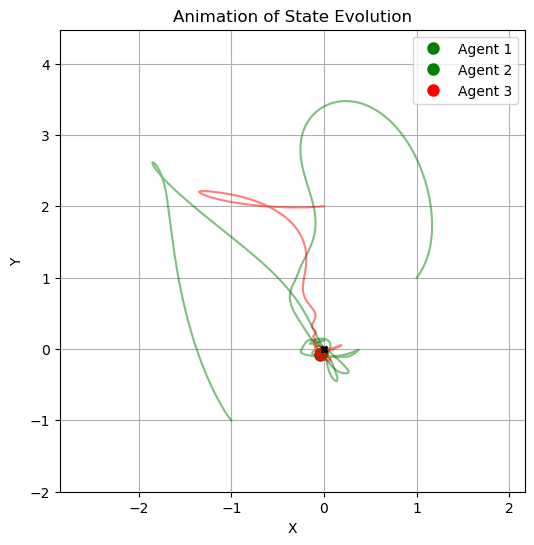

In [10]:
make_video(t_solution, y_solution, name="2dogs1sheep")

# Generalizing to arbitrary number of Dogs

To do this is not too difficult, one just needs to keep track of the subscripts very carefully. Note that the differential equation for the $k^{\text{th}}$ dog is given by:
$$\begin{align}
\begin{bmatrix}
x_{d_k}\\
y_{d_k}\\
v_{x_{d_k}}\\
v_{y_{d_k}}
\end{bmatrix}'=\begin{bmatrix}
v_{x_{d_k}}\\
v_{y_{d_k}}\\
u_{x_{d_k}}\\
u_{y_{d_k}}
\end{bmatrix}
\end{align}$$
and the differential equation for the $i^{\text{th}}$ sheep is given by:
$$\begin{align}
\begin{bmatrix}
x_{s_i}\\
y_{s_i}\\
v_{x_{s_i}}\\
v_{y_{s_i}}
\end{bmatrix}'=\begin{bmatrix}
v_{x_{s_i}}\\
v_{y_{s_i}}\\
a(s_i)\\
b(s_i)
\end{bmatrix}\\
a(s_i)=\sum\limits_{d_k}^{}\left(\frac{x_{s_i}-x_{d_k}}{((x_{s_i}-x_{d_k})^2+(y_{s_i}-y_{d_k})^2)^{\frac{\lambda }{2}}}\right)\\
=\sum\limits_{d_k}^{}a_P(s_i,d_k)\\
b(s_i)=\sum\limits_{d_k}^{}\left(\frac{y_{s_i}-y_{d_k}}{((x_{s_i}-x_{d_k})^2+(y_{s_i}-y_{d_k})^2)^{\frac{\lambda }{2}}}\right)\\
=\sum\limits_{d_k}^{}b_P(s_i,d_k)\\
\end{align}$$
Where the $i^{th}$ sheep moves a weighted combination away from the nearest dogs. The reason we define this $a_p,b_p$ is so that we only have to find a derivative of a few terms instead of a sum in sympy.

We also generalize the cost functional as follows:
$$\begin{align}
J[u]=\int_0^{t_f}\alpha\sum_{s_i}(x_{s_i}^2+y_{s_i}^2)\\
+\beta\sum_{d_k}(x_{d_k}^2+y_{d_k}^2)+\sum_{d_k}(u_{x_{d_k}}^2+u_{y_{d_k}}^2)dt
\end{align}$$
So the Hamiltonian is thus given by:
$$\begin{align}
H=p\cdot f-L\\
=\sum_{d_k}\left(p_{d_k}^{(1)}v_{x_{d_k}}+p_{d_k}^{(2)}v_{y_{d_k}}+p_{d_k}^{(3)}u_{x_{d_k}}+p_{d_k}^{(4)}u_{y_{d_k}}\right)\\
+\sum_{s_i}\left(p_{s_i}^{(1)}v_{x_{s_i}}+p_{s_i}^{(2)}v_{y_{s_i}}+p_{s_i}^{(3)}a(s_i)+p_{s_i}^{(4)}b(s_i)\right)\\
-\alpha\sum_{s_i}(x_{s_i}^2+y_{s_i}^2)
-\beta\sum_{d_k}(x_{d_k}^2+y_{d_k}^2)-\sum_{d_k}(u_{x_{d_k}}^2+u_{y_{d_k}}^2)
\end{align}$$

Using this we can derive costate equations for our dogs and sheep. To do this note that to find $(p_{d_k}^{(1)})'$ we need to take the derivative with respect to $x_{d_k}$ and so on.
$$\begin{align}
\begin{bmatrix}
p_{d_k}^{(1)}\\
p_{d_k}^{(2)}\\
p_{d_k}^{(3)}\\
p_{d_k}^{(4)}
\end{bmatrix}'=-\begin{bmatrix}
\sum_{s_i}(p_{s_i}^{(3)}\frac{da}{dx_{d_k}}+p_{s_i}^{(4)}\frac{db}{dx_{d_k}})-2\beta x_{d_k}\\
\sum_{s_i}(p_{s_i}^{(3)}\frac{da}{dy_{d_k}}+p_{s_i}^{(4)}\frac{db}{dy_{d_k}})-2\beta y_{d_k}\\
p_{d_k}^{(1)}\\
p_{d_k}^{(2)}
\end{bmatrix}
\end{align}$$
by linearity of derivative we can further reduce the $\frac{db}{dx_{d_k}}=\sum_{d_k}\frac{d}{dx_k}b_P(s_i,d_k)=\frac{d}{dx_k}b_P(s_i,d_k)$ to get:
$$\begin{align}
=-\begin{bmatrix}
\sum_{s_i}(p_{s_i}^{(3)}\frac{da_P}{dx_{d_k}}(s_i,d_k)+p_{s_i}^{(4)}\frac{db_P}{dx_{d_k}}(s_i,d_k))-2\beta x_{d_k}\\
\sum_{s_i}(p_{s_i}^{(3)}\frac{da_P}{dy_{d_k}}(s_i,d_k)+p_{s_i}^{(4)}\frac{db_P}{dy_{d_k}}(s_i,d_k))-2\beta y_{d_k}\\
p_{d_k}^{(1)}\\
p_{d_k}^{(2)}
\end{bmatrix}
\end{align}$$

And similarly for the sheep costate equations:
$$\begin{align}
\begin{bmatrix}
p_{s_i}^{(1)}\\
p_{s_i}^{(2)}\\
p_{s_i}^{(3)}\\
p_{s_i}^{(4)}
\end{bmatrix}'=-\begin{bmatrix}
p_{s_i}^{(3)}\frac{da}{dx_{s_i}}(s_i)+p_{s_i}^{(4)}\frac{db}{dx_{s_i}}(s_i)-2\alpha x_{s_i}\\
p_{s_i}^{(3)}\frac{da}{dy_{s_i}}(s_i)+p_{s_i}^{(4)}\frac{db}{dy_{s_i}}(s_i)-2\alpha y_{s_i}\\
p_{s_i}^{(1)}\\
p_{s_i}^{(2)}
\end{bmatrix}
\end{align}$$
when noting the linearity of the derivative $\frac{db}{dx_{s_i}}=\sum_{d_k}\frac{d}{dx_{s_i}}b_P(s_i,d_k)$:
$$\begin{align}
=-\begin{bmatrix}
p_{s_i}^{(3)}\sum_{d_k}\frac{d}{dx_{s_i}}a_P(s_i,d_k)+p_{s_i}^{(4)}\sum_{d_k}\frac{d}{dx_{s_i}}b_P(s_i,d_k)-2\alpha x_{s_i}\\
p_{s_i}^{(3)}\sum_{d_k}\frac{d}{dy_{s_i}}a_P(s_i,d_k)+p_{s_i}^{(4)}\sum_{d_k}\frac{d}{dy_{s_i}}b_P(s_i,d_k)-2\alpha y_{s_i}\\
p_{s_i}^{(1)}\\
p_{s_i}^{(2)}
\end{bmatrix}
\end{align}$$

Finally we need to find the controls. Deriving the above equation with respect to the controls we get:
$$\begin{align}
\begin{bmatrix}
p_{d_k}^{(3)}-2u_{x_{d_k}}\\
p_{d_k}^{(4)}-2u_{y_{d_k}}
\end{bmatrix}=0\\
\begin{bmatrix}
u_{x_{d_k}}\\
u_{y_{d_k}}
\end{bmatrix}=\begin{bmatrix}
\frac{p_{d_k}^{(3)}}{2}\\
\frac{p_{d_k}^{(4)}}{2}
\end{bmatrix}
\end{align}$$

Now note that we have a very large system. We have the intial positions for each of our state variables and we have the final position for each of our costate variables $p(t_f)=0$. We can substitute in the control to have the differential equation for our state and costate be completely specified. 

We do not compute any of the derivatives of $b_P,a_P$ by hand because we are lazy and can use sympy.

In [54]:
# Create the symbols and expression
x_d_k, y_d_k, x_s_i, y_s_i = sp.symbols("x_{d_k} y_{d_k} x_{s_i} y_{s_i}")
lambd, alpha, beta = 3, 300, 2
epsilon = 1e-3
dist = sp.sqrt((x_s_i-x_d_k)**2 + (y_s_i-y_d_k)**2 + epsilon)
a_P = (x_s_i-x_d_k)/(dist**lambd)
b_P = (y_s_i-y_d_k)/(dist**lambd)
# Find the derivative and lambdify it into a function
a_pxd = sp.lambdify((x_d_k, y_d_k, x_s_i, y_s_i), sp.simplify(sp.diff(a_P, x_d_k)))
a_pyd = sp.lambdify((x_d_k, y_d_k, x_s_i, y_s_i), sp.simplify(sp.diff(a_P, y_d_k)))
a_pxs = sp.lambdify((x_d_k, y_d_k, x_s_i, y_s_i), sp.simplify(sp.diff(a_P, x_s_i)))
a_pys = sp.lambdify((x_d_k, y_d_k, x_s_i, y_s_i), sp.simplify(sp.diff(a_P, y_s_i)))
# Now for the b versions
b_pxd = sp.lambdify((x_d_k, y_d_k, x_s_i, y_s_i), sp.simplify(sp.diff(b_P, x_d_k)))
b_pyd = sp.lambdify((x_d_k, y_d_k, x_s_i, y_s_i), sp.simplify(sp.diff(b_P, y_d_k)))
b_pxs = sp.lambdify((x_d_k, y_d_k, x_s_i, y_s_i), sp.simplify(sp.diff(b_P, x_s_i)))
b_pys = sp.lambdify((x_d_k, y_d_k, x_s_i, y_s_i), sp.simplify(sp.diff(b_P, y_s_i)))
# Lambdify the original functions as well, because we will use it later
a_P = sp.lambdify((x_d_k, y_d_k, x_s_i, y_s_i), a_P)
b_P = sp.lambdify((x_d_k, y_d_k, x_s_i, y_s_i), b_P)

Following the standard from earlier. We will define our first $4D+4S$ variables to be the state variable where $D$ is the total number of Dogs and $S$ is the total number of sheep. We then define the next $4D+4S$ variables to be their corresponding costate variables.

In [55]:
S = 2
D = 3
def ode(t, y):    
    state = y[:4*(D+S)]
    costate = y[4*(D+S):]
    state_derivs = np.zeros((4*(D+S),len(y[0])))
    costate_derivs = np.zeros((4*(D+S),len(y[0])))
    
    # First get the Dog state derivatives
    for k in range(D):
        v_x_d = state[2+4*k]
        v_y_d = state[3+4*k]
        state_derivs[0+4*k] = v_x_d
        state_derivs[1+4*k] = v_y_d
        u_x_d = costate[2+4*k]/2
        u_y_d = costate[3+4*k]/2
        state_derivs[2+4*k] = u_x_d
        state_derivs[3+4*k] = u_y_d
        
    # Sheep State derivatives
    for i in range(D,D+S):
        v_x_s = state[2+4*i]
        v_y_s = state[3+4*i]
        state_derivs[0+4*i] = v_x_s
        state_derivs[1+4*i] = v_y_s
        x_s_i = state[0+4*i]
        y_s_i = state[1+4*i]
        a = 0
        b = 0
        for k in range(D):
            x_d_k = state[0+4*k]
            y_d_k = state[1+4*k]
            a += a_P(x_d_k, y_d_k, x_s_i, y_s_i)
            b += b_P(x_d_k, y_d_k, x_s_i, y_s_i)
        state_derivs[2+4*i] = a
        state_derivs[3+4*i] = b
        
    # Costate Dogs
    for k in range(D):
        x_d_k = state[0+4*k]
        y_d_k = state[1+4*k]
        costate_1_sum = -2*beta*x_d_k
        costate_2_sum = -2*beta*y_d_k
        for i in range(D,D+S):
            x_s_i = state[0+4*i]
            y_s_i = state[1+4*i]
            costate_1_sum += costate[2+4*i]*a_pxd(x_d_k, y_d_k, x_s_i, y_s_i) + costate[3+4*i]*b_pxd(x_d_k, y_d_k, x_s_i, y_s_i)
            costate_2_sum += costate[2+4*i]*a_pyd(x_d_k, y_d_k, x_s_i, y_s_i) + costate[3+4*i]*b_pyd(x_d_k, y_d_k, x_s_i, y_s_i)
        costate_derivs[0+4*k] = -costate_1_sum
        costate_derivs[1+4*k] = -costate_2_sum
        costate_derivs[2+4*k] = -costate[0+4*k]
        costate_derivs[3+4*k] = -costate[1+4*k]
    
    # Costate Sheep
    for i in range(D,D+S):
        x_s_i = state[0+4*i]
        y_s_i = state[1+4*i]
        costate_1_sum = -2*alpha*x_s_i
        costate_2_sum = -2*alpha*y_s_i
        for k in range(D):
            x_d_k = state[0+4*k]
            y_d_k = state[1+4*k]
            costate_1_sum += costate[2+4*i]*a_pxs(x_d_k, y_d_k, x_s_i, y_s_i) + costate[3+4*i]*b_pxs(x_d_k, y_d_k, x_s_i, y_s_i) 
            costate_2_sum += costate[2+4*i]*a_pys(x_d_k, y_d_k, x_s_i, y_s_i) + costate[3+4*i]*b_pys(x_d_k, y_d_k, x_s_i, y_s_i) 
        costate_derivs[0+4*i] = -costate_1_sum
        costate_derivs[1+4*i] = -costate_2_sum
        costate_derivs[2+4*i] = -costate[0+4*i]
        costate_derivs[3+4*i] = -costate[1+4*i]
    return np.concatenate([state_derivs, costate_derivs])
x0 = np.random.normal(size=(4*(D+S)))
def bc(y0, yT):
    # Initial conditions on states
    # x0 = np.array([1, 1, 2, 3, -1, -1, -3, 4, 0, 2, 0, 0,0,0,0,0])
    # x0 = np.array([1, 1, 2, 3, -1, -1, -3, 4, 0, 2, 0, 0, 0, -2,0,0])
    state_initial = y0[:4*(D+S)] - x0  # x(0) = x0
    # Final conditions on costates
    costate_final = yT[4*(D+S):]       # p(T) = 0
    return np.concatenate([state_initial, costate_final])

In [56]:
# Time discretization
tf = 10.0  # Total time
num_points = 50  # Number of points in the grid
t = np.linspace(0, tf, num_points)

# Initial guess (random or based on heuristics)
y_guess = np.ones(((D+S)*8, num_points)) # 12 state + 12 costate variables
y_guess[:4*(D+S)] *= x0[:,None] 
y_guess[:4*(D+S)] += np.cumsum(np.cumsum(np.random.normal(size=num_points)))
y_guess[4*(D+S):] *= 0
y_guess[4*(D+S):] += np.cumsum(np.cumsum(np.random.normal(size=num_points)))[::-1]
# y_guess = .5*np.random.normal(size=((D+S)*8, num_points))  # 12 state + 12 costate variables
# Solve BVP
solution = solve_bvp(ode, bc, t, y_guess, verbose=2, max_nodes=2000)

# Extract solution
t_solution = solution.x
y_solution = solution.y
print(solution.success)

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          8.63e+02       7.32e-01          50             98       
       2          4.50e+03       5.66e-01          148            294      
       3          1.58e+04       4.37e-01          442            882      
       4          4.83e+04       3.15e-01         1324          (2646)     
Number of nodes is exceeded after iteration 4. 
Maximum relative residual: 4.83e+04 
Maximum boundary residual: 3.15e-01
False


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '600x600', '-pix_fmt', 'rgba', '-framerate', '30', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '2dogs1sheep.mp4']' returned non-zero exit status 255.

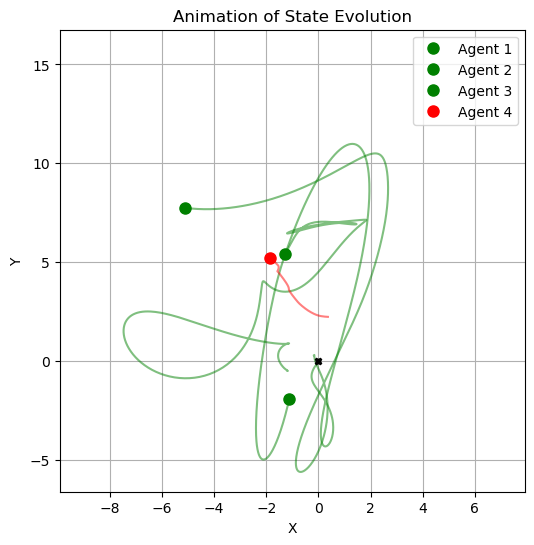

In [55]:
make_video(t_solution, y_solution, name="2dogs1sheep", D=D, S=S)